In [24]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords

# Spacy for lemmatization
import spacy

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Podcast Topic Modeling

What I aim to do with this project is to find out what topics have been, and are being discussed in 4 different podcasts - The Joe Rogan Experience, The H3 Podcast, The Tony Robbins Podcast, and The Stuff You Should Know Podcast.

I will use snippets from all episodes from the different podcasts that I have transcribed myself. Due to the poor transcription quality, I have decided to end this project for now. Instead I plan to work on the [Spotify Podcast Dataset and Trec Challenge](https://labs.spotify.com/2020/04/16/introducing-the-spotify-podcast-dataset-and-trec-challenge-2020/).

Below is not a polished project, but some code to show initiative and competency in the field.

## First steps

- Load in the data
- Get bi-/trigrams

In [11]:
df = pd.DataFrame({'Podcast': os.listdir('Text')})
podcast_texts = []
for podcast in df['Podcast']:
    text = ''
    path = os.path.join('Text', podcast)
    for ep_snippet in os.listdir(path):
        with open(os.path.join(path, ep_snippet), 'r') as f:
            text += f.readline()
    podcast_texts.append(text)
df['Content'] = podcast_texts

Now we have a dataframe with the documents as rows:

In [16]:
df

,Podcast,Content
0,H3,the only regarding you can't why can't i be ex...
1,JRE,i'm barbara will at a long hot sauces during o...
2,SYSK,right to buy their reinvented two thousand twe...
3,TR,you wanna try to sell those himself he would n...


Now let's 'tokenize' each word, meaning we put each word as an element in a list that acts as an element in the document list.

In [12]:
#Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(podcast_texts))

Now let's attempt to bigram these text.

In [19]:
#Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [46]:
print(bigram_mod[data_words[0]])

['the', 'only', 'regarding', 'you', 'can', 'why', 'can', 'be', 'explained', 'as', 'know', 'was', 'gonna', 'really', 'raises', 'some', 'weird', 'had', 'an', 'eye', 'on', 'him', 'as', 'good', 'analyst', 'at', 'this', 'moment', 'is', 'with', 'the', 'gun', 'ban', 'suzanne', 'do', 'to', 'it', 'it', 'was', 'tied', 'to', 'express', 'my', 'aunt', 'who', 'had', 'him', 'thought', 'the', 'book', 'without', 'those', 'carrying', 'things', 'don', 'feel', 'myself', 'agonized', 'and', 'can', 'handle', 'businesses', 'that', 'you', 'know', 'that', 'racism', 'when', 'lie', 'memories', 'of', 'eck', 'will', 'no', 'longer', 'live', 'and', 'at', 'some', 'anyway', 'there', 'was', 'good', 'cold', 'sounds', 'furlong', 'thousand', 'to', 'pa', 'never', 'did', 'ever', 'sawthe', 'smoky', 'six', 'million', 'in', 'five', 'months', 'never', 'been', 'before', 'her', 'head', 'and', 'the', 'thighs', 'next', 'delia', 'live', 'performance', 'we', 'watched', 'it', 'loud', 'led', 'those', 'treacherous', 'where', 'there', 'wa

With a threshold of 100, there isn't a single bigram found in the text. Usually with proper text data (like the Newsgroup data) there should be some bigrams found, but here Gensim's bigram model was unable to find a single one. I believe this shows that the data is of a low quality. I personally think of the data to be low quality, since it was transcribed with a light version of CMU Sphinx -- Pocketsphinx.

Since the data is poor, having a small threshold would likely be problematic, as it would reduce the count of important words like 'talking' by combining it to 'talking_about', therefore reducing the frequency of the word 'talking' to the frequency of a false word like 'prophecieson' or 'predictdidn'.

Of course, it could be the case that words like 'talking_about' are actually incorrectly transcribed, but I would imagine if the transcription came up with words that end up categorized as bigrams there's a higher than normal chance they hhave been correctly transcribed. Regardless, speculating on what the transcription algorithm did isn't helpful for the purpose of topic modelling whatever data I have.

Let's move on keeping the threshold at 100.

## Removing stopwords and lemmatization

In [21]:
#Code from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data_words_processed = lemmatization(remove_stopwords(data_words))

In [29]:
data_words_processed[1][:10]

['long',
 'hot',
 'sauce',
 'last',
 'may',
 'month',
 'would',
 'argue',
 'news',
 'get']

There we go! Looking 'good'.

## 11. Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_processed)

# Create Corpus
texts = data_words_processed

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 2), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 4), (10, 2), (11, 3), (12, 13), (13, 2), (14, 11), (15, 1), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 8), (29, 1), (30, 1), (31, 1), (32, 1), (33, 5), (34, 1), (35, 5), (36, 1), (37, 3), (38, 1), (39, 5), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 3), (55, 8), (56, 2), (57, 18), (58, 1), (59, 1), (60, 1), (61, 8), (62, 1), (63, 1), (64, 2), (65, 1), (66, 4), (67, 1), (68, 3), (69, 3), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 6), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 5), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 3), (92, 1), (93, 1), (94, 1), (95, 1), (96, 3), (97, 2), (98, 1), (99, 1), (100, 2), (101, 1), (102, 2), (103, 1), (104, 1), (105, 1), (106, 1), (107, 2), (108, 1), (109, 2), (110,

## 12. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [42]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## 13. View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [47]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"go" + 0.006*"people" + 0.005*"know" + 0.005*"get" + 0.005*"want" + '
  '0.004*"time" + 0.004*"think" + 0.003*"say" + 0.003*"look" + 0.003*"would"'),
 (1,
  '0.002*"know" + 0.002*"go" + 0.001*"get" + 0.001*"think" + 0.001*"say" + '
  '0.001*"thing" + 0.001*"good" + 0.001*"would" + 0.001*"right" + '
  '0.001*"make"'),
 (2,
  '0.001*"go" + 0.001*"know" + 0.001*"get" + 0.001*"right" + 0.000*"say" + '
  '0.000*"thing" + 0.000*"people" + 0.000*"think" + 0.000*"would" + '
  '0.000*"look"'),
 (3,
  '0.017*"know" + 0.016*"go" + 0.014*"get" + 0.011*"say" + 0.010*"people" + '
  '0.010*"would" + 0.009*"think" + 0.009*"thing" + 0.008*"good" + '
  '0.007*"right"'),
 (4,
  '0.004*"go" + 0.003*"know" + 0.003*"get" + 0.002*"say" + 0.002*"thing" + '
  '0.002*"think" + 0.002*"right" + 0.002*"people" + 0.002*"good" + '
  '0.002*"really"')]


## 14. Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_processed, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.836342606371379

Coherence Score:  0.2150971252696338


## 15. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.154835  0.008165       1        1  98.447716
0      0.012845 -0.038141       2        1   1.547593
4     -0.015914  0.023109       3        1   0.001639
1     -0.058566  0.006738       4        1   0.001597
2     -0.093200  0.000128       5        1   0.001462, topic_info=     Category         Freq      Term        Total  loglift  logprob
770   Default  1532.000000        go  1532.000000  30.0000  30.0000
964   Default  1603.000000      know  1603.000000  29.0000  29.0000
762   Default  1339.000000       get  1339.000000  28.0000  28.0000
1471  Default   988.000000       say   988.000000  27.0000  27.0000
1701  Default   882.000000     think   882.000000  26.0000  26.0000
1246  Default   920.000000    people   920.000000  25.0000  25.0000
1700  Default   796.000000     thing   796.000000  24.0000  24.0000
1874  Default   909.000000     would   909.000000  23.0000  23.0000
1439  Default   691.000000     right   691.000000  22.0000  22.0000
773   Default   714.000000      good   714.000000  21.0000  21.0000
1379  Default   690.000000    really   690.000000  20.0000  20.0000
336   Default   592.000000      come   592.000000  19.0000  19.0000
1818  Default   544.000000      want   544.000000  18.0000  18.0000
1060  Default   567.000000      make   567.000000  17.0000  17.0000
1037  Default   507.000000      look   507.000000  16.0000  16.0000
1715  Default   429.000000      time   429.000000  15.0000  15.0000
1670  Default   406.000000      take   406.000000  14.0000  14.0000
206   Default   311.000000      bomb   311.000000  13.0000  13.0000
1789  Default   448.000000       use   448.000000  12.0000  12.0000
1497  Default   482.000000       see   482.000000  11.0000  11.0000
1880  Default   386.000000      year   386.000000  10.0000  10.0000
1867  Default   344.000000      work   344.000000   9.0000   9.0000
1827  Default   337.000000       way   337.000000   8.0000   8.0000
1884  Default   277.000000       yet   277.000000   7.0000   7.0000
57    Default   330.000000      also   330.000000   6.0000   6.0000
183   Default   330.000000       big   330.000000   5.0000   5.0000
263   Default   304.000000      call   304.000000   4.0000   4.0000
393   Default   354.000000     could   354.000000   3.0000   3.0000
1041  Default   319.000000       lot   319.000000   2.0000   2.0000
141   Default   321.000000      back   321.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
1439   Topic5     0.000688     right   691.015686  -2.6871  -7.6001
762    Topic5     0.000774       get  1339.605835  -3.2315  -7.4825
1700   Topic5     0.000608     thing   796.184570  -2.9526  -7.7239
1471   Topic5     0.000620       say   988.453796  -3.1486  -7.7037
1701   Topic5     0.000588     think   882.362000  -3.0883  -7.7569
1246   Topic5     0.000591    people   920.953369  -3.1253  -7.7510
1037   Topic5     0.000474      look   507.236450  -2.7506  -7.9728
1874   Topic5     0.000517     would   909.966125  -3.2478  -7.8855
1818   Topic5     0.000462      want   544.934204  -2.8485  -7.9990
773    Topic5     0.000469      good   714.654358  -3.1035  -7.9828
1379   Topic5     0.000458    really   690.440247  -3.0919  -8.0057
336    Topic5     0.000427      come   592.092834  -3.0083  -8.0758
1060   Topic5     0.000418      make   567.528931  -2.9888  -8.0987
1497   Topic5     0.000396       see   482.058411  -2.8789  -8.1520
206    Topic5     0.000339      bomb   311.807983  -2.5985  -8.3072
1715   Topic5     0.000356      time   429.603271  -2.8713  -8.2596
1880   Topic5     0.000344      year   386.704742  -2.7998  -8.2933
1789   Topic5     0.000340       use   448.319733  -2.9582  -8.3039
12     Topic5     0.000307  actually   263.075012  -2.5269  -8.4056
1884   Topic5     0.000308       yet   277.925751  -2.5796  -8.4034
57     Topic5     0.000316      also   330.

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [51]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_processed, start=2, limit=10)

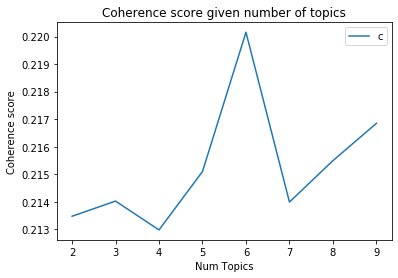

In [54]:
limit=10; start=2;
x = range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("Coherence score given number of topics")
plt.show()